In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,20)})
import random 
from datetime import datetime, timedelta
from bisect import *

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_fault_data = pd.read_csv('/content/drive/My Drive/fault_data.csv')
df_scada_data = pd.read_csv('/content/drive/My Drive/scada_data.csv')
# df_fault_data = pd.read_csv('fault_data.csv')
# df_scada_data = pd.read_csv('scada_data.csv')

In [ ]:
df_scada_data.drop(['WEC: Production minutes', 'Pitch cabinet blade A temp.', 'Pitch cabinet blade B temp.',
       'Pitch cabinet blade C temp.', 'Main carrier temp.',
       'Rectifier cabinet temp.', ],axis=1,inplace=True)
df_scada_data.drop('WEC: max. windspeed',axis=1,inplace=True)
df_scada_data.drop('WEC: min. windspeed',axis=1,inplace=True)
df_scada_data.drop('WEC: max. Rotation',axis=1,inplace=True)
df_scada_data.drop('WEC: min. Rotation',axis=1,inplace=True)
df_scada_data.drop('WEC: max. Power',axis=1,inplace=True)
df_scada_data.drop('WEC: min. Power',axis=1,inplace=True)
df_scada_data.drop('WEC: Production kWh',axis=1,inplace=True)
df_scada_data.drop(['WEC: ava. reactive Power',
       'WEC: max. reactive Power', 'WEC: min. reactive Power',
       'WEC: ava. available P from wind',
       'WEC: ava. available P technical reasons',
       'WEC: ava. Available P force majeure reasons',
       'WEC: ava. Available P force external reasons'],axis=1,inplace=True)
df_scada_data.drop(['Sys 1 inverter 1 cabinet temp.',
       'Sys 1 inverter 2 cabinet temp.', 'Sys 1 inverter 3 cabinet temp.',
       'Sys 1 inverter 4 cabinet temp.', 'Sys 1 inverter 5 cabinet temp.',
       'Sys 1 inverter 6 cabinet temp.', 'Sys 1 inverter 7 cabinet temp.',
       'Sys 2 inverter 1 cabinet temp.', 'Sys 2 inverter 2 cabinet temp.',
       'Sys 2 inverter 3 cabinet temp.', 'Sys 2 inverter 4 cabinet temp.',
       'Sys 2 inverter 5 cabinet temp.', 'Sys 2 inverter 6 cabinet temp.',
       'Sys 2 inverter 7 cabinet temp.'],axis=1,inplace=True)
df_scada_data.drop([ 'Blade A temp.', 'Blade C temp.', 'Rotor temp. 2',
       'Stator temp. 2', 'Nacelle ambient temp. 1', 'Nacelle ambient temp. 2',
       'Nacelle cabinet temp.', 'RTU: ava. Setpoint 1',
       'Inverter averages', 'Inverter std dev'],axis=1,inplace=True)

In [ ]:
df_scada_data.columns

Index(['DateTime', 'Time', 'Error', 'WEC: ava. windspeed',
       'WEC: ava. Rotation', 'WEC: ava. Power',
       'WEC: ava. Nacel position including cable twisting',
       'WEC: Operating Hours', 'WEC: ava. blade angle A', 'Spinner temp.',
       'Front bearing temp.', 'Rear bearing temp.', 'Blade B temp.',
       'Rotor temp. 1', 'Stator temp. 1', 'Nacelle temp.',
       'Yaw inverter cabinet temp.', 'Fan inverter cabinet temp.',
       'Ambient temp.', 'Tower temp.', 'Control cabinet temp.',
       'Transformer temp.'],
      dtype='object')

In [ ]:
df_main = pd.merge(df_scada_data, df_fault_data, how='left')
df_main

,DateTime,Time,Error,WEC: ava. windspeed,WEC: ava. Rotation,WEC: ava. Power,WEC: ava. Nacel position including cable twisting,WEC: Operating Hours,WEC: ava. blade angle A,Spinner temp.,Front bearing temp.,Rear bearing temp.,Blade B temp.,Rotor temp. 1,Stator temp. 1,Nacelle temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,Fault
0,05-01-2014 00:00,1398920448,0,6.9,0.00,0,640,881,91.959999,13,13,13,166,15,15,14,20,25,12,14,24,34,NaN
1,05-01-2014 00:09,1398920960,0,5.3,0.00,0,640,881,91.959999,13,13,13,166,15,15,13,20,25,12,14,24,34,NaN
2,05-01-2014 00:20,1398921600,0,5.0,0.00,0,640,881,91.940002,13,13,13,166,15,15,13,20,25,12,14,24,34,NaN
3,05-01-2014 00:30,1398922240,0,4.4,0.00,0,641,881,91.949997,13,13,13,166,15,15,13,21,25,12,14,24,34,NaN
4,05-01-2014 00:39,1398922752,0,5.7,0.00,0,633,881,91.940002,13,13,13,166,15,15,13,21,25,12,14,23,34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49022,04-08-2015 23:20,1428553216,0,3.9,6.75,147,148,7884,1.000000,18,24,29,165,46,46,16,23,28,9,17,27,35,NaN
49023,04-08-2015 23:30,1428553856,0,3.9,6.64,128,148,7884,1.000000,18,24,29,165,46,46,16,23,28,9,17,27,35,NaN
49024,04-08-2015 23:39,1428554368,0,4.2,7.18,163,149,7884,1.000000,18,24,29,165,46,46,16,23,28,9,18,27,34,NaN
49025,04-08-2015 23:50,1428555008,0,4.1,7.02,160,151,7884,1.000000,18,24,30,165,46,46,16,23,28,9,17,27,34,NaN


In [ ]:
dict2=pd.Series(df_fault_data.Fault.values,index=df_fault_data.Time).to_dict()

In [ ]:
for time in dict2:
    df_main.loc[df_main['Time']==time, 'Fault'] = dict2[time]

In [ ]:
df_main['Fault']=df_main['Fault'].fillna("No Fault")
df_main

,DateTime,Time,Error,WEC: ava. windspeed,WEC: ava. Rotation,WEC: ava. Power,WEC: ava. Nacel position including cable twisting,WEC: Operating Hours,WEC: ava. blade angle A,Spinner temp.,Front bearing temp.,Rear bearing temp.,Blade B temp.,Rotor temp. 1,Stator temp. 1,Nacelle temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,Fault
0,05-01-2014 00:00,1398920448,0,6.9,0.00,0,640,881,91.959999,13,13,13,166,15,15,14,20,25,12,14,24,34,No Fault
1,05-01-2014 00:09,1398920960,0,5.3,0.00,0,640,881,91.959999,13,13,13,166,15,15,13,20,25,12,14,24,34,No Fault
2,05-01-2014 00:20,1398921600,0,5.0,0.00,0,640,881,91.940002,13,13,13,166,15,15,13,20,25,12,14,24,34,No Fault
3,05-01-2014 00:30,1398922240,0,4.4,0.00,0,641,881,91.949997,13,13,13,166,15,15,13,21,25,12,14,24,34,No Fault
4,05-01-2014 00:39,1398922752,0,5.7,0.00,0,633,881,91.940002,13,13,13,166,15,15,13,21,25,12,14,23,34,No Fault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49022,04-08-2015 23:20,1428553216,0,3.9,6.75,147,148,7884,1.000000,18,24,29,165,46,46,16,23,28,9,17,27,35,No Fault
49023,04-08-2015 23:30,1428553856,0,3.9,6.64,128,148,7884,1.000000,18,24,29,165,46,46,16,23,28,9,17,27,35,No Fault
49024,04-08-2015 23:39,1428554368,0,4.2,7.18,163,149,7884,1.000000,18,24,29,165,46,46,16,23,28,9,18,27,34,No Fault
49025,04-08-2015 23:50,1428555008,0,4.1,7.02,160,151,7884,1.000000,18,24,30,165,46,46,16,23,28,9,17,27,34,No Fault


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
df_main.drop('DateTime',axis=1,inplace=True)
df_main.drop('Time',axis=1,inplace=True)
df_main.drop('Error',axis=1,inplace=True)

In [ ]:
df_main

,WEC: ava. windspeed,WEC: ava. Rotation,WEC: ava. Power,WEC: ava. Nacel position including cable twisting,WEC: Operating Hours,WEC: ava. blade angle A,Spinner temp.,Front bearing temp.,Rear bearing temp.,Blade B temp.,Rotor temp. 1,Stator temp. 1,Nacelle temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,Fault
0,6.9,0.00,0,640,881,91.959999,13,13,13,166,15,15,14,20,25,12,14,24,34,No Fault
1,5.3,0.00,0,640,881,91.959999,13,13,13,166,15,15,13,20,25,12,14,24,34,No Fault
2,5.0,0.00,0,640,881,91.940002,13,13,13,166,15,15,13,20,25,12,14,24,34,No Fault
3,4.4,0.00,0,641,881,91.949997,13,13,13,166,15,15,13,21,25,12,14,24,34,No Fault
4,5.7,0.00,0,633,881,91.940002,13,13,13,166,15,15,13,21,25,12,14,23,34,No Fault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49022,3.9,6.75,147,148,7884,1.000000,18,24,29,165,46,46,16,23,28,9,17,27,35,No Fault
49023,3.9,6.64,128,148,7884,1.000000,18,24,29,165,46,46,16,23,28,9,17,27,35,No Fault
49024,4.2,7.18,163,149,7884,1.000000,18,24,29,165,46,46,16,23,28,9,18,27,34,No Fault
49025,4.1,7.02,160,151,7884,1.000000,18,24,30,165,46,46,16,23,28,9,17,27,34,No Fault


In [ ]:
df_main['Fault'].unique()

In [ ]:
X=df_main.drop('Fault',axis=1)
y=df_main['Fault']

# Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
unique, count = np.unique(y_smote, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{'AF': 48581,
 'EF': 48581,
 'FF': 48581,
 'GF': 48581,
 'MF': 48581,
 'No Fault': 48581}

In [ ]:
X_smote.shape

(291486, 19)

In [ ]:
y_smote.shape

(291486,)

In [ ]:
fs = SelectKBest(score_func=f_classif, k=8)
# apply feature selection
selector = fs.fit(X_smote, y_smote)

In [ ]:
cols = selector.get_support(indices=True)
cols

array([ 0,  2,  7,  8, 10, 11, 17, 18])

In [ ]:
new_X = pd.DataFrame(X_smote)
new_X = new_X.iloc[:,cols]

In [ ]:
new_X.columns

Int64Index([0, 2, 7, 8, 10, 11, 17, 18], dtype='int64')

# Neural networks

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(new_X)
new_X = scaler.transform(new_X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y_smote, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
label_encoder = LabelEncoder() 

#Fit label encoder and return encoded labels as a vector
vector_train = label_encoder.fit_transform(y_train) #create a vector
vector_test = label_encoder.fit_transform(y_test)

#Convert to categorical
y_train = to_categorical(vector_train)
y_test = to_categorical(vector_test)

In [ ]:
print(y_train)
print()
print(y_test)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]

[[0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]]


In [ ]:
model = Sequential()
model.add(Dense(24, input_dim=8, activation='relu')) 
model.add(Dropout(0.2))

model.add(Dense(15, activation='relu')) 
model.add(Dropout(0.2))

model.add(Dense(12, activation='relu')) 

model.add(Dense(6, activation='softmax'))   

model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary()) 



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                216       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                375       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                192       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 78        
Total params: 861
Trainable params: 861
Non-trainable params: 0
________________________________________________________

In [ ]:
history = model.fit(X_train, y_train ,verbose=1, epochs=100, batch_size=64,
                    validation_data=(X_test, y_test))


Train on 233188 samples, validate on 58298 samples
Epoch 1/100
233188/233188 [==============================] - 12s 51us/step - loss: 0.9930 - accuracy: 0.5888 - val_loss: 0.6496 - val_accuracy: 0.7477
Epoch 2/100
233188/233188 [==============================] - 10s 44us/step - loss: 0.6871 - accuracy: 0.7214 - val_loss: 0.5221 - val_accuracy: 0.7867
Epoch 3/100
233188/233188 [==============================] - 10s 44us/step - loss: 0.6114 - accuracy: 0.7538 - val_loss: 0.4628 - val_accuracy: 0.8095
Epoch 4/100
233188/233188 [==============================] - 13s 56us/step - loss: 0.5701 - accuracy: 0.7675 - val_loss: 0.4398 - val_accuracy: 0.8107
Epoch 5/100
233188/233188 [==============================] - 14s 58us/step - loss: 0.5467 - accuracy: 0.7755 - val_loss: 0.4202 - val_accuracy: 0.8237
Epoch 6/100
233188/233188 [==============================] - 13s 57us/step - loss: 0.5314 - accuracy: 0.7817 - val_loss: 0.4168 - val_accuracy: 0.8202
Epoch 7/100
233188/233188 [===============

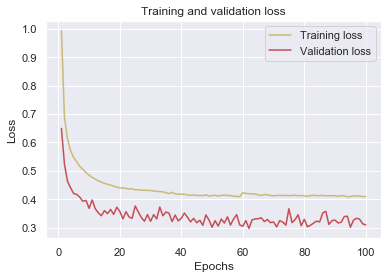

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

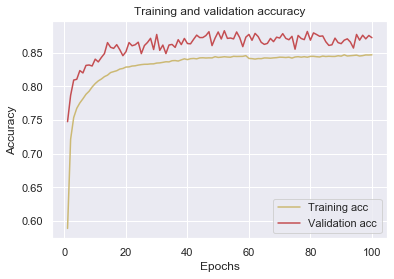

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Neural network Hypertuning

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid

In [ ]:
def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=8))
            model.add(Activation(activation))
            model.add(Dropout(0.2))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
            model.add(Dropout(0.2))
            
    model.add(Dense(6, activation='softmax')) 
    
    model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model
    
model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:

layers = [(20,), (16, 16), (32, 16, 16)]
activations = ['relu']
param_grid = dict(layers=layers, activation=activations, batch_size = (64, 128), epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3)

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
[grid_result.best_score_,grid_result.best_params_]

[0.8258228500684103,
 {'activation': 'relu',
  'batch_size': 64,
  'epochs': 30,
  'layers': (32, 16, 16)}]